In [1]:
# imports
import numpy as np
import math
import pandas as pd
import requests
import matplotlib.pyplot as plt

Here, I download files to perform the analysis

In [2]:
# # download the CSV files from GitHub
# base_url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/"

# for y in range(1995, 2025):
#     file_name = f"atp_matches_{y}.csv"
#     url = base_url + file_name
#     r = requests.get(url)
    
#     if r.status_code == 200:
#         with open(file_name, "wb") as f:
#             f.write(r.content)
#         print(f"{file_name} downloaded successfully.")
#     else:
#         print(f"Failed to download {file_name}.")
        
# # The files are manually moved to a folder named 'atp_matches'

In [3]:
# # Inspect the first few rows and columns of three sample files
# sample_years = [1995, 2005, 2015]

# # base path
# base_path = "/Users/jonas/Documents/GitHub/Tennis-ML-Project/atp_matches/"

# for year in sample_years:
#     file_name = f"atp_matches_{year}.csv"
#     df = pd.read_csv(base_path + file_name)
#     print(f"\nData from {file_name}:")
#     print(df.iloc[:5, :10])

In [4]:
# # base path
# base_path = "/Users/jonas/Documents/GitHub/Tennis-ML-Project/atp_matches/"

# # the files appear to have consistent structure across years, so they are combined into a single DataFrame
# all_data = []

# for year in range(1995, 2025):
#     file_name = f"atp_matches_{year}.csv"
#     df = pd.read_csv(base_path + file_name)
#     all_data.append(df)
    
# # concatenate all data into a single DataFrame
# combined_df = pd.concat(all_data, ignore_index=True)

# # save the combined DataFrame to a new CSV file for easier access later
# combined_df.to_csv("atp_matches_combined.csv", index=False)


Here, I inspect and clean the data for further analysis and modeling

In [5]:
# get a overview of the combined DataFrame
df = pd.read_csv("atp_matches_combined.csv")

# # column names and data types
# print(df.dtypes)

I use DataWrangler to inspect the data

In [6]:
# Remove first five values from turney_id
df["tourney_id"] = df["tourney_id"].str[5:]

# convert tournament date to datetime
df["tourney_date"] = pd.to_datetime(df["tourney_date"], format="%Y%m%d")



# remove implausible height measurements (<150 cm)
df = df[(df["winner_ht"] > 150) | (df["winner_ht"].isna())]
df = df[(df["loser_ht"]  > 150) | (df["loser_ht"].isna())]

# extract year for grouped imputations
df["year"] = df["tourney_date"].dt.year

# impute missing heights
# first: country-by-year mean
# fallback: year-level mean
df["winner_ht"] = (
    df["winner_ht"]
      .fillna(df.groupby(["winner_ioc", "year"])["winner_ht"].transform("mean"))
      .fillna(df.groupby("year")["winner_ht"].transform("mean"))
)
df["loser_ht"] = (
    df["loser_ht"]
      .fillna(df.groupby(["loser_ioc", "year"])["loser_ht"].transform("mean"))
      .fillna(df.groupby("year")["loser_ht"].transform("mean"))
)


# drop all rows for which tourney_level is 'D'
df = df[df["tourney_level"] != "D"]


# impute missing match duration using tournament-level means
df["minutes"] = (
    df.groupby("tourney_id")["minutes"]
      .transform(lambda x: x.fillna(x.mean()))
)


# drop columns that are not useful for the analysis
cols_to_drop = ["winner_entry",
       "winner_seed", "winner_rank", "winner_rank_points", 
       "loser_entry", "loser_seed", "loser_rank",
       "loser_rank_points", "year"
]

df = df.drop(columns=cols_to_drop)

# drop remaining rows with missing values
df = df.dropna()


In [7]:
# rename columns for easier access
df = df.rename(columns={
    "winner_name": "player_name",
    "winner_id": "player_id",
    "loser_id": "opp_id",
    "loser_name": "opp_name",
    "winner_hand": "player_hand",
    "loser_hand": "opp_hand",
    "winner_ht": "player_ht",
    "loser_ht": "opp_ht",
    "winner_ioc": "player_ioc",
    "loser_ioc": "opp_ioc",
    "winner_age": "player_age",
    "loser_age": "opp_age",
    
    "w_ace": "player_ace",
    "l_ace": "opp_ace",
    "w_df": "player_df",
    "l_df": "opp_df",
    "w_svpt": "player_svpt",
    "l_svpt": "opp_svpt",
    
    "w_1stIn": "player_1stIn",
    "l_1stIn": "opp_1stIn",
    "w_1stWon": "player_1stWon",
    "l_1stWon": "opp_1stWon",
    "w_2ndWon": "player_2ndWon",
    "l_2ndWon": "opp_2ndWon",
    
    "w_SvGms": "player_SvGms",
    "l_SvGms": "opp_SvGms",
    
    "w_bpSaved": "player_bpSaved",
    "l_bpSaved": "opp_bpSaved",
    "w_bpFaced": "player_bpFaced",
    "l_bpFaced": "opp_bpFaced",
})

# reorder columns
new_order = [
    "tourney_id", "tourney_name", "tourney_date", "tourney_level", 
    "match_num", "round", "draw_size", "best_of", "score", "surface", 

    "player_id", "opp_id",
    "player_name", "opp_name",

    "player_hand", "opp_hand",
    "player_ht", "opp_ht",
    "player_ioc", "opp_ioc",
    "player_age", "opp_age",

    "minutes",

    "player_ace", "opp_ace",
    "player_df", "opp_df",
    "player_svpt", "opp_svpt",
    "player_1stIn", "opp_1stIn",
    "player_1stWon", "opp_1stWon",
    "player_2ndWon", "opp_2ndWon",
    "player_SvGms", "opp_SvGms",
    "player_bpSaved", "opp_bpSaved",
    "player_bpFaced", "opp_bpFaced",
]
df = df[new_order]

# add a win column
df["win"] = 1  # since the player_id column corresponds to the winner


Here, I engineer features for modelling. Features have a initialization period of 5 years.

Match-centric features are created here

In [8]:
# function to compute player Elo rating
def elo_rating(df, surface="All", K=32, initial_rating=1500):
    
    # sort values
    df = df.sort_values(by=["tourney_date", "tourney_id", "match_num"]).reset_index(drop=True).copy()
    
    # create masks for surfaces
    if surface == "All":
        mask = df["surface"].isin(["Hard", "Clay", "Grass", "Carpet"])
    else:
        mask = df["surface"] == surface
        
    # create empty columns
    df[f"player_Elo{surface}"], df[f"opp_Elo{surface}"] = np.nan, np.nan
    
    elo = {}
    
    for i, row in df[mask].iterrows():
        
        # find player and opp id
        player = row["player_id"]
        opp = row["opp_id"]
        
        # ensure that players cannot play against themselves
        if player == opp:
            raise ValueError("player_id equals opp_id")
        
        # if player exists: get Elo rating from dict
        # else: set Elo to initial rating
        elo[player] = elo.get(player, initial_rating)
        elo[opp] = elo.get(opp, initial_rating)
        
        # update dataframes
        df.at[i, f"player_Elo{surface}"] = elo[player]
        df.at[i, f"opp_Elo{surface}"] = elo[opp]
        
        # find win-probabilities, initial is 50-50
        opp_prob = 1 / (1 + 10**((elo[player]-elo[opp])/400))
        player_prob = 1 - opp_prob # Due to symmetry
        
        # Outcome is strictly win for the player, hence set to 1
        elo[player] += K * (1-player_prob)
        elo[opp] += K * (0-opp_prob)
        
    return df

# call function
surfaces = ["All", "Hard", "Clay", "Grass", "Carpet"]

for surface_ in surfaces:
    df = elo_rating(df, surface=surface_)
    
# impute missing values with zero, hence the algorithm doesn't see either players elo for Grass if the game is played on Clay
df = df.fillna(0)   

In [9]:
# H2H winning streak
# first win starts streak at 1 for the winner
# and loss resets his streak to 0
# no transfer of streak from winner to loser!

def head_to_head_win_streak(df, cap=3):
    
    # sort values
    df = (
        df.sort_values(by=["tourney_date", "tourney_id", "match_num"])
          .reset_index(drop=True)
          .copy()
    )
    
    df["player_H2hStreak"], df["opp_H2hStreak"] = 0, 0
    
    # dict: unordered pair -> (last_winner, streak_len)
    h2h = {}
    
    for i, row in df.iterrows():
        
        winner = row["player_id"]
        loser = row["opp_id"]
        
        if winner == loser:
            raise ValueError("player_id equals opp_id")
        
        pair = tuple(sorted((winner, loser)))
        
        # pre-match streak
        if pair not in h2h:
            s = 0
        else:
            last_winner, streak_len = h2h[pair]
            s = streak_len if last_winner == winner else 0
        
        # write pre-match values
        df.at[i, "player_H2hStreak"] = s
        df.at[i, "opp_H2hStreak"] = -s
        
        # update state after match
        if pair not in h2h:
            h2h[pair] = (winner, 1)
        else:
            last_winner, streak_len = h2h[pair]
            if last_winner == winner:
                h2h[pair] = (winner, min(cap, streak_len + 1))
            else:
                # streak dies completely
                h2h[pair] = (winner, 1)
    
    return df

# call function
df = head_to_head_win_streak(df, cap=3)

Note: Add match-centric features for weather conditions. 

Player-centric features are created here

In [10]:
# Create a symmetric dataset by duplicating and swapping player and opponent data
df_swapped = df.copy()
player_cols = [col for col in df.columns if col.startswith("player")] 
opp_cols = [col for col in df.columns if col.startswith("opp")]

df_swapped[player_cols], df_swapped[opp_cols] = df[opp_cols].values, df[player_cols].values

df_swapped["win"] = 0  # the swapped dataset corresponds to losses

# Combine original and swapped datasets
df = pd.concat([df, df_swapped], ignore_index=True)

In [11]:
# generate player statistics
df.sort_values(by=["tourney_date", "tourney_id", "match_num"])

# SPW
# Measures overall serve effectiveness. Higher values indicate stronger serve performance across both first and second serves.
df["SPW"] = (df["player_1stWon"] + df["player_2ndWon"]).div(
    df["player_svpt"].where(df["player_svpt"] > 0)
)

# RPW
# Measures return strength and ability to win points when receiving serve. Higher values indicate stronger return performance.
df["RPW"] = 1 - (df["opp_1stWon"] - df["opp_2ndWon"]).div(
    df["opp_svpt"].where(df["opp_svpt"] > 0)
)

# Hold
# Captures reliability on serve at the game level. High values indicate consistent service games and clutch performance under break-point pressure.
df["Hold"] = 1 - (df["opp_1stWon"] - df["opp_2ndWon"]).div(
    df["player_SvGms"].where(df["player_SvGms"] > 0)
)

# Break
# Measures effectiveness on return at the game level. High values indicate strong ability to convert break-point opportunities.
df["Break"] = (df["opp_bpFaced"] - df["opp_bpSaved"]).div(
    df["opp_SvGms"].where(df["opp_SvGms"] > 0)
)

# AceRate
# Captures serve dominance via unreturnable serves.
df["AceRate"] = df["player_ace"].div(
    df["player_svpt"].where(df["player_svpt"] > 0)
)

# DFRate
df["DFRate"] = df["player_df"].div(
    df["player_svpt"].where(df["player_svpt"] > 0)
)

In [12]:
# function to get rolling mean for each the player-centric statistics
# needed for calculation of exponentially weighted moving average for each player
def expanding_mean(df, column_name, SUB_END_DATE="2000-01-01"):
    
    # sort df
    df = (df.sort_values(by=["tourney_date", "tourney_id", "match_num"])
          .reset_index(drop=True)
          .copy()
    )
    
    # find location of last row of sub
    sub = df[df["tourney_date"] <= pd.Timestamp(SUB_END_DATE)]
    last_row = len(sub) - 1
    
    # use row location to use as start of expanding mean
    df[f"mean_{column_name}"] = (df[column_name]
                                 .expanding(last_row)
                                 .mean()
    )
    
    # backfill: constant mean for the first 5 years
    df[f"mean_{column_name}"] = df[f"mean_{column_name}"].bfill()
    
    return df
    
# call function
player_centric_features = ["SPW", "RPW", "Hold", "Break", "AceRate", "DFRate"]

for feature in player_centric_features:
    df = expanding_mean(df, column_name=feature)    

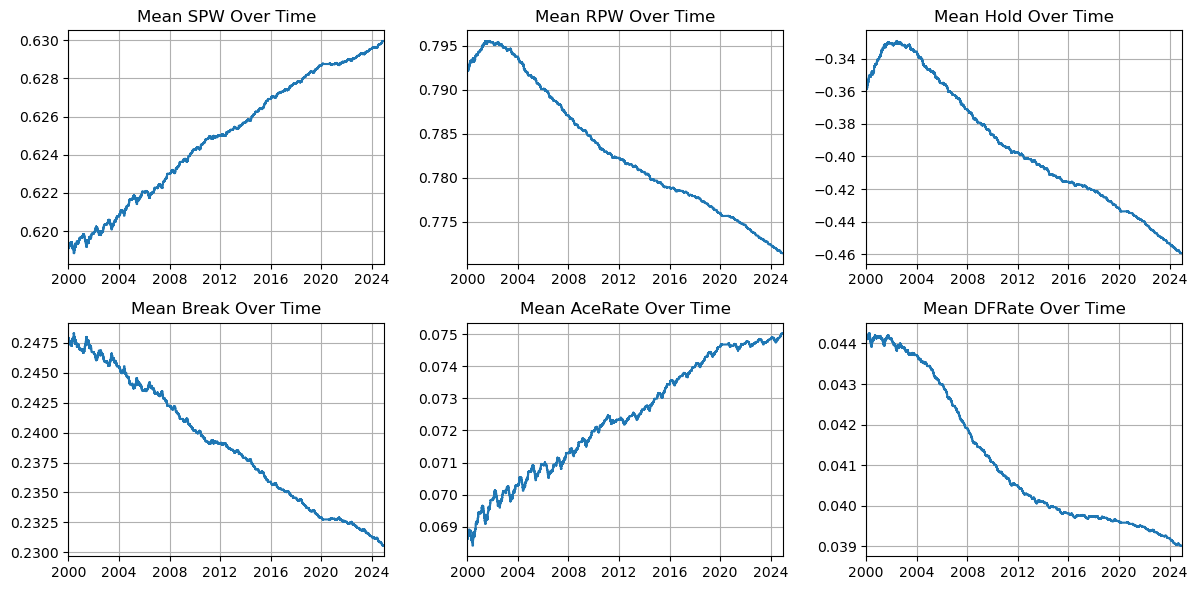

In [16]:
# Plot of player-centric features over time starting from 2000
plt.figure(figsize=(12, 6))
for i, feature in enumerate(player_centric_features, 1):
    plt.subplot(2, 3, i)
    plt.plot(df["tourney_date"], df[f"mean_{feature}"], label=f"Mean {feature}")
    plt.title(f"Mean {feature} Over Time")
    plt.xlim(pd.Timestamp("2000-01-01"), df["tourney_date"].max())
    plt.grid()
plt.tight_layout()
plt.show() 

Since the population means of the performance metrics evolve over time, it is important to initialise player states using time-varying baseline values rather than a fixed constant.

In [ ]:
# function to get exponentially weighted moving average features for each player
def player_EWMA_feature(df, HALFTIME=5):
    
    # sort df
    df = (df.sort_values(by=["tourney_date", "tourney_id", "match_num"])
          .reset_index(drop=True)
          .copy())
    
    for i, row in df.iterrows():
        m_0 = 
    
    
    
